<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>From tensorflow model training to scoring with</b></font><font face="monospace" size="4" color="darkblue"><b> watson-machine-learning-client</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning Service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning repository.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning reposutory.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Train TensorFlow model](#model)
3.	[Persist model](#save)
4.	[Deploy model](#deploy)
5.	[Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a lite plan is offered). 
-  Create [Object Storage OpenStack Swift](https://console.bluemix.net/catalog/services/object-storage) instance (a lite plan is offered).
- Upload [training mnist data](http://yann.lecun.com/exdb/mnist/) to previously created Object Storage OpenStack Swift.

<a id="model"></a>
## 2. Train model

### 2.1 Work with the instance

In [16]:
import urllib3, requests, json, base64, time, os

In [ ]:
!pip install dask --upgrade

Authenticate to Watson Machine Learning service on Bluemix.

**Action**: Put authentication information from your instance of Watson Machine Learning service here.

In [2]:
wml_credentials={
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "***",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

#### Install `watson-machine-learning-client` from pypi

In [6]:
!pip install --upgrade --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.python.org/simple/ watson-machine-learning-client

    100% |████████████████████████████████| 307kB 1.3MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 1.9MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 938kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 2.1MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 1.1MB/s eta 0:00:01
    100% |████████████████████████████████| 337kB 3.2MB/s eta 0:00:01
    100% |████████████████████████████████| 25.7MB 48kB/s  eta 0:00:01
Requirement already up-to-date: six>=1.10.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from lomond->watson-machine-learning-client)
    100% |████████████████████████████████| 143kB 7.4MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 2.2MB/s eta 0:00:01
Requirement already up-to-date: python-dateutil>=2 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-package

#### Import `watson-machine-learning-client` and authenticate to service instance

In [2]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [3]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 2.2 Save model definition 

#### Prepare model definition metadata

**Tip:** You can leave `TRAINING_DATA_REFERENCE` values empty as shown in example below.

In [4]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "my_definition",
            client.repository.DefinitionMetaNames.DESCRIPTION: "my_description",
            client.repository.DefinitionMetaNames.AUTHOR_NAME: "John Smith",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "js@js.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.2",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.TRAINING_DATA_REFERENCE: [
                    {
                        "name": "sample reference",
                        "connection": {},
                        "source": {}
                    }
                ],
            }

#### Get sample model definition content file from git

In [5]:
if os.path.isfile('tf-softmax-model.zip'):
    !ls tf-softmax-model.zip
else:
    !wget https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip
    !ls tf-softmax-model.zip

--2017-12-02 05:53:08--  https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip [following]
--2017-12-02 05:53:09--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3847 (3.8K) [application/zip]
Saving to: ‘tf-softmax-model.zip’

100%[===========

#### Publish training definition in Watson Machine Learning repository

In [6]:
training_definition_url = client.repository.store_definition('tf-softmax-model.zip', model_definition_metadata)

In [7]:
print(training_definition_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/experiments/1d360bd9-143f-496c-adc5-3aeb724b2a43/versions/bee5ce04-6b01-4c1e-b31b-95e4acfcbeaa


### 2.3 Train model

#### Prepare training configuration

**Action:** Put authentication information from your instance of Object Storage service here.
- `TRAINING_DATA_REFERENCE` (reference to uploaded training data)
- `TRAINING_RESULTS_REFERENCE` (location where trained model will be saved)

In [ ]:
training_configuration_metadata = {
            client.training.ConfigurationMetaNames.NAME: "Hand-written Digit Recognition",
            client.training.ConfigurationMetaNames.AUTHOR_NAME: "John Smith",
            client.training.ConfigurationMetaNames.DESCRIPTION: "Hand-written Digit Recognition training",
            client.training.ConfigurationMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.training.ConfigurationMetaNames.FRAMEWORK_VERSION: "1.2-py3",
            client.training.ConfigurationMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 100",
            client.training.ConfigurationMetaNames.EXECUTION_RESOURCE_SIZE: "small",
            client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: [
                {
                    "connection": {
                        "auth_url": "https://identity.open.softlayer.com/v3",
                        "user_name": "***",
                        "password": "***",
                        "region": "dallas",
                        "domain_name": "***",
                        "project_id": "***"
                        
                    },
                    "source": {
                        "bucket": "name",
                        "type": "bluemix_objectstore"
                    }
                }
            ],
            client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
                    "connection": {
                        "auth_url": "https://identity.open.softlayer.com/v3",
                        "user_name": "***",
                        "password": "***",
                        "region": "dallas",
                        "domain_name": "***",
                        "project_id": "***"
                        
                    },
                    "source": {
                        "bucket": "name",
                        "type": "bluemix_objectstore"
                    }
            }
        }

#### Train the model in the background

In [20]:
training_run_guid_asynch = client.training.run(training_definition_url, training_configuration_metadata)

In [21]:
details = client.training.get_details(training_run_guid_asynch)

You can check status of training run by calling below method.

In [22]:
status = client.training.get_status(training_run_guid_asynch)
print(json.dumps(status, indent=2))

{
  "metrics": [],
  "submitted_at": "2017-12-02T11:58:53Z",
  "state": "running",
  "current_at": "2017-12-02T11:58:53Z",
  "message": "Status: PENDING\n"
}


#### Monitor training log

You can turn on training log monitoring by calling below method.

In [23]:
client.training.monitor(training_run_guid_asynch)

Log monitor started.
Status: PENDING

Training with training/test data at:
  DATA_DIR: /job/dl-data
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: python3 tensorflow_mnist_softmax.py --trainingIters 100
Storing trained model at:
  RESULT_DIR: /job/dl-models

ALERTMANAGER_PORT=tcp://172.21.217.38:9093
ALERTMANAGER_PORT_9093_TCP=tcp://172.21.217.38:9093
ALERTMANAGER_PORT_9093_TCP_ADDR=172.21.217.38

ALERTMANAGER_PORT_9093_TCP_PORT=9093

ALERTMANAGER_PORT_9093_TCP_PROTO=tcp

ALERTMANAGER_SERVICE_HOST=172.21.217.38
ALERTMANAGER_SERVICE_PORT=9093

ALERTMANAGER_SERVICE_PORT_ALERTMANAGER=9093
BAZEL_VERSION=0.4.5

CI_BUILD_PYTHON=python3
CUDA_PKG_VERSION=8-0=8.0.61-1

CUDA_VERSION=8.0.61

CUDNN_VERSION=5.1.10
DATA_DIR=/job/dl-data

DLAAS_LCM_PORT=tcp://172.21.187.102:80
DLAAS_LCM_PORT_80_TCP=tcp://172.21.187.102:80
DLAAS_LCM_PORT_80_TCP_ADDR=172.21.187.102
DLAAS_LCM_PORT_80_TCP_PORT=80
DLAAS_LCM_PORT_80_TCP_PROTO=tcp
DLAAS_LCM_SERVICE_HOST=172.21.187.102
DLAAS_LCM_SERVICE_PO

Log monitor done.


#### Cancel training

You can cancel training run by calling below method.

#### Train the model in active mode

**Tip:** You can also run training in synchronous mode by setting `asynchronous = False`

In [24]:
training_run_guid = client.training.run(training_definition_url, training_configuration_metadata, asynchronous=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Training started ...
Elapsed time: 0.1599869728088379 -> training state: running


  0%|          | 0/10 [00:00<?, ?it/s]

Elapsed time: 10.28866982460022 -> training state: running


  0%|          | 0/10 [00:00<?, ?it/s]

Elapsed time: 20.42673397064209 -> training state: pending


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Elapsed time: 30.530693769454956 -> training state: running


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Training DONE.


#### Get training runs details

In [ ]:
training_details = client.training.get_details()

print(json.dumps(training_details, sort_keys=True, indent=2))

#### List training runs

In [26]:
client.training.list()

------------------  ---------  --------------------  ----------
GUID (training)     STATE      CREATED               FRAMEWORK
training-0zdwv2Ukg  completed  2017-12-02T11:59:33Z  tensorflow
training-9iiPD28kR  error      2017-12-02T11:57:47Z  tensorflow
training-J9iUDhUkR  completed  2017-12-02T11:58:52Z  tensorflow
training-KUcfDh8kR  error      2017-12-02T11:56:52Z  tensorflow
------------------  ---------  --------------------  ----------


<a id="model"></a>
## 3. Persist model

#### Call this method to save model in Watson Machine Learning repository

In [27]:
saved_model_details = client.repository.store_model(training_run_guid, "My cool mnist model")

In [28]:
print("Url: " + saved_model_details['entity']['ml_asset_url'])

Url: https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/913e9341-7453-4cc1-81b5-a7e01cd53f33


**Tip:** Run below code to extract stored model guid from dictionary.

In [29]:
model_guid = saved_model_details['entity']['ml_asset_guid']
print("Saved model guid: " + model_guid)

Saved model guid: 913e9341-7453-4cc1-81b5-a7e01cd53f33


#### Call this method to list stored models

In [30]:
client.repository.list()

------------------------------------  -------------------------  --------------
GUID                                  NAME                       FRAMEWORK
f5f8e460-2cf4-471f-91a9-37be1779a251  Best Heart Drug Selection  mllib-2.0
913e9341-7453-4cc1-81b5-a7e01cd53f33  My cool mnist model        tensorflow-1.2
------------------------------------  -------------------------  --------------


#### Delete training-run and its results

You can delete train runs and results by running below method.

In [31]:
client.training.delete(training_run_guid_asynch)
client.training.delete(training_run_guid)

True

## 5. Create online deployment

You can deployed stored model as webservice (online) by running below method.

In [32]:
deployment_details = client.deployments.create(model_guid, name="Mnist model deployment")

In [33]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/765597ba-cf7a-4995-9cfc-06dae368b741/published_models/913e9341-7453-4cc1-81b5-a7e01cd53f33/deployments/045f6ff5-0632-428b-a8be-95032585f692/online


## 6. Scoring

Prepare sample scoring data to score deployed model.

In [37]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [38]:
image1 = mnist.test.images[45,].tolist()
image2 = mnist.test.images[4,].tolist()

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

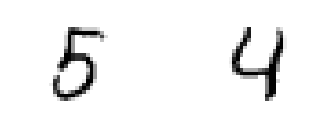

In [40]:
for i, image in enumerate([image1, image2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow( (np.reshape(image, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

Build scoring disctionary consisting of two digits and send it to deployed model to get predictions.

In [41]:
scoring_data = {'inputs': [image1, image2]}

In [42]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'classes': [5, 4]}


<a id="summary"></a>
## 6. Summary and next steps     

 You successfully completed this notebook! You learned how to use Continuous Learning System of Watson Machine Learning. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist in IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.